In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time


2024-12-05 12:08:37.842183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733396917.855648   61634 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733396917.859833   61634 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 12:08:37.875235: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()


In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]


In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256


In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


I0000 00:00:1733396920.905255   61634 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10180 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

/home/cyril/Workspace/Python/Artificial-Intelligence-and-Neural-Networks/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1733396929.439621   61634 cuda_dnn.cc:529] Loaded cuDNN version 90300


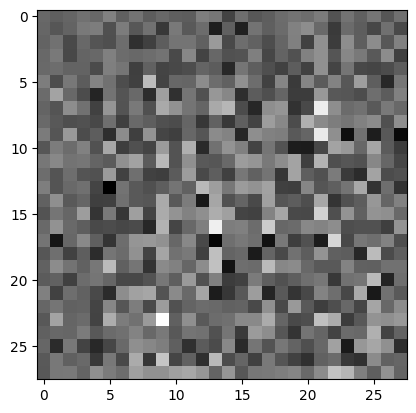

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[-0.00047874]], shape=(1, 1), dtype=float32)


/home/cyril/Workspace/Python/Artificial-Intelligence-and-Neural-Networks/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [14]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [16]:
def train(dataset, epochs):
  for epoch in range(epochs):
    print('Epoch {}'.format(epoch + 1))
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [17]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  
  plt.show()


Epoch 1


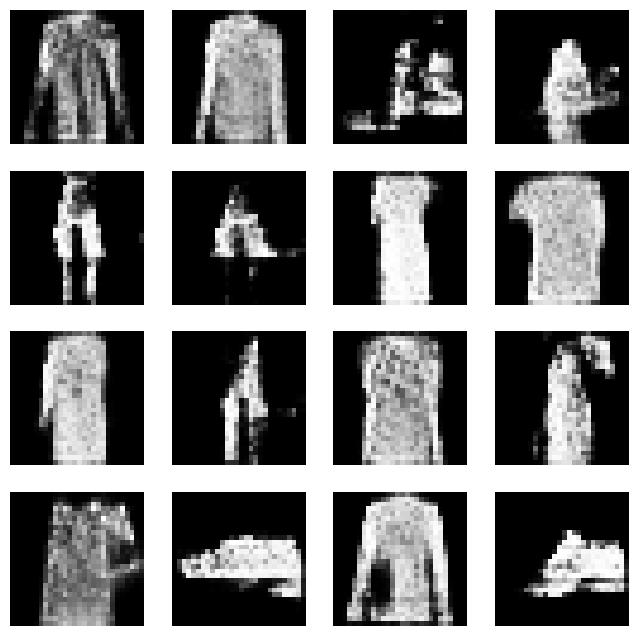

Time for epoch 1 is 5.623715162277222 sec
Epoch 2


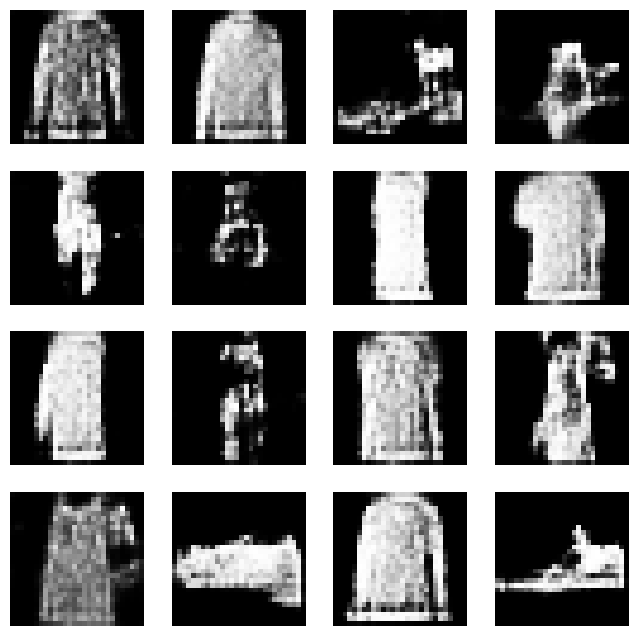

Time for epoch 2 is 5.39781641960144 sec
Epoch 3


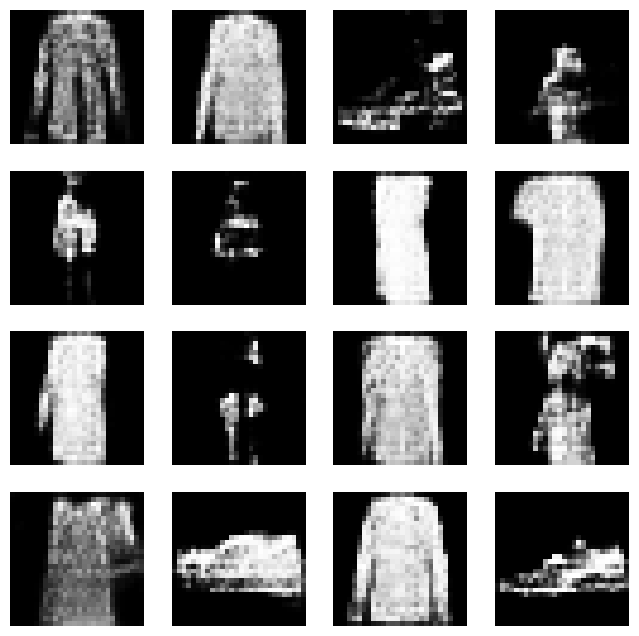

Time for epoch 3 is 5.376233100891113 sec
Epoch 4


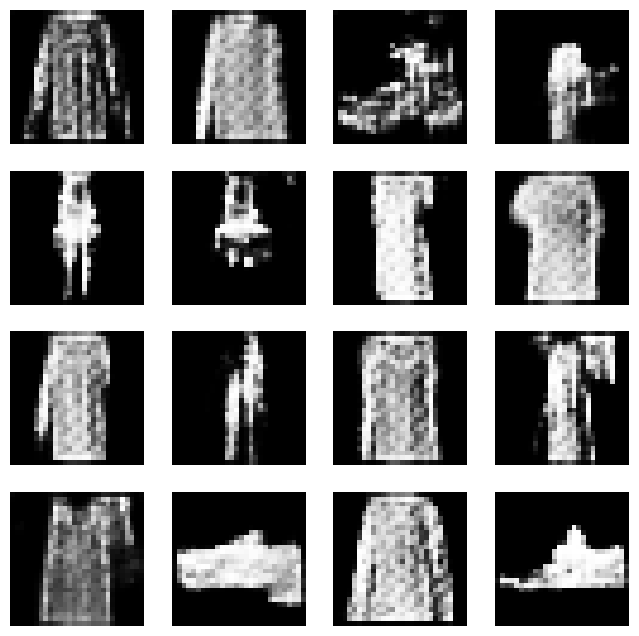

Time for epoch 4 is 5.378307104110718 sec
Epoch 5


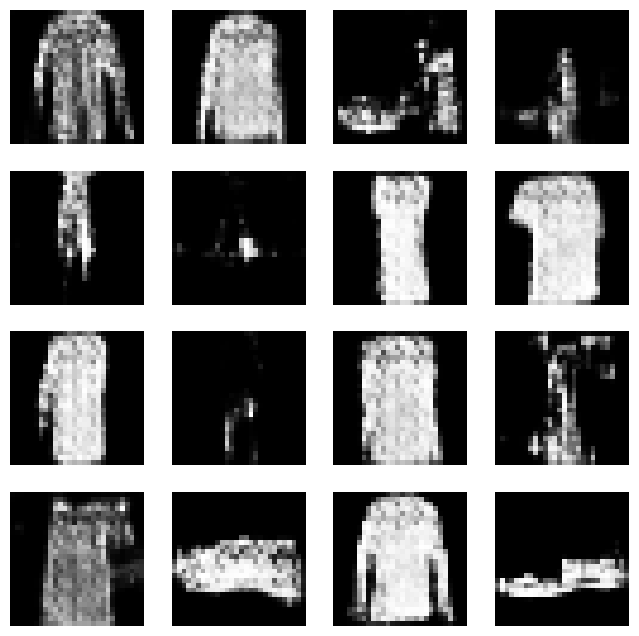

Time for epoch 5 is 5.630490779876709 sec
Epoch 6


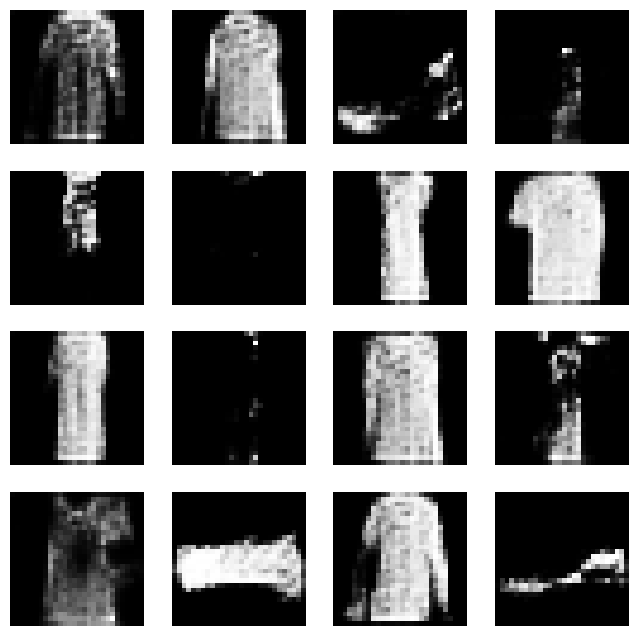

Time for epoch 6 is 5.391634225845337 sec
Epoch 7


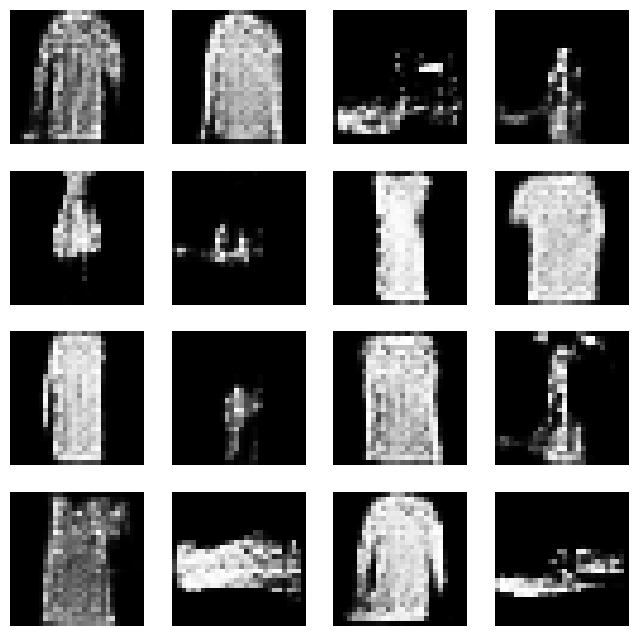

Time for epoch 7 is 5.392382860183716 sec
Epoch 8


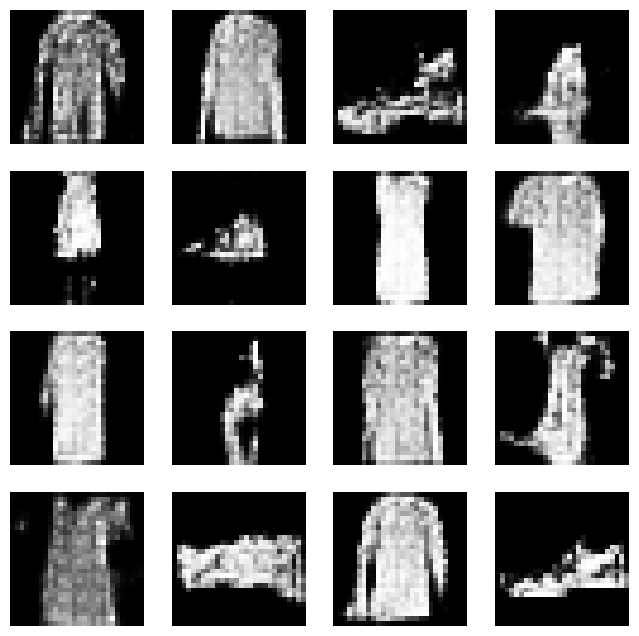

Time for epoch 8 is 5.405726909637451 sec
Epoch 9


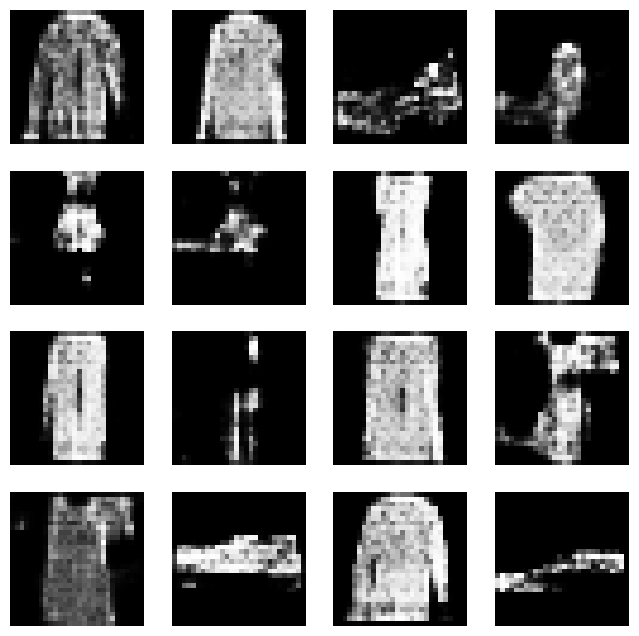

Time for epoch 9 is 5.406095743179321 sec
Epoch 10


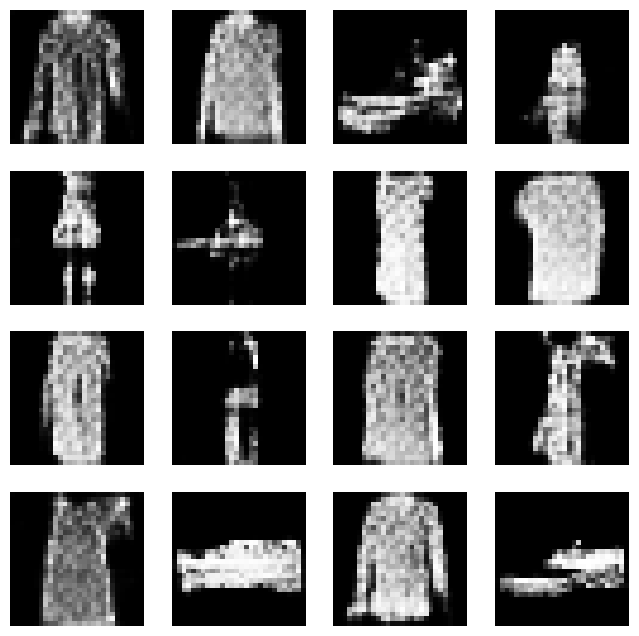

Time for epoch 10 is 5.665620803833008 sec
Epoch 11


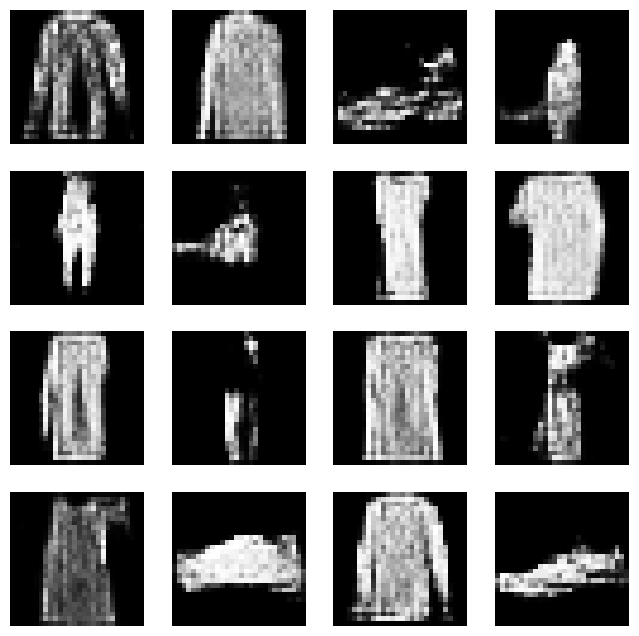

Time for epoch 11 is 5.403716325759888 sec
Epoch 12


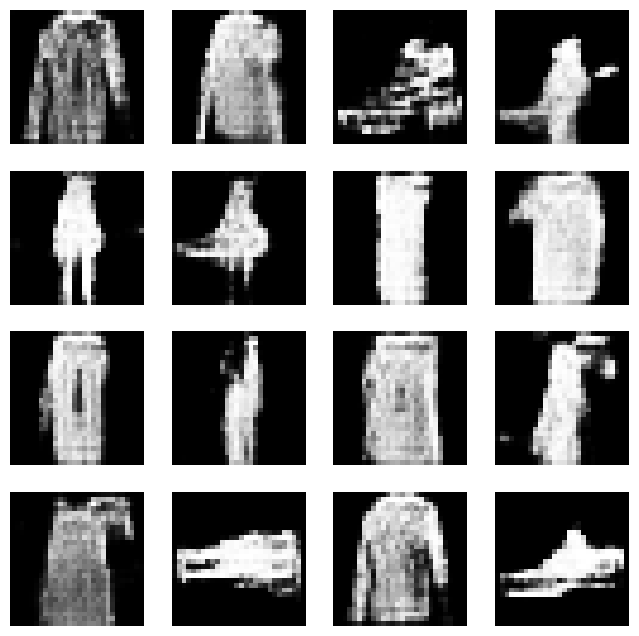

Time for epoch 12 is 5.402562141418457 sec
Epoch 13


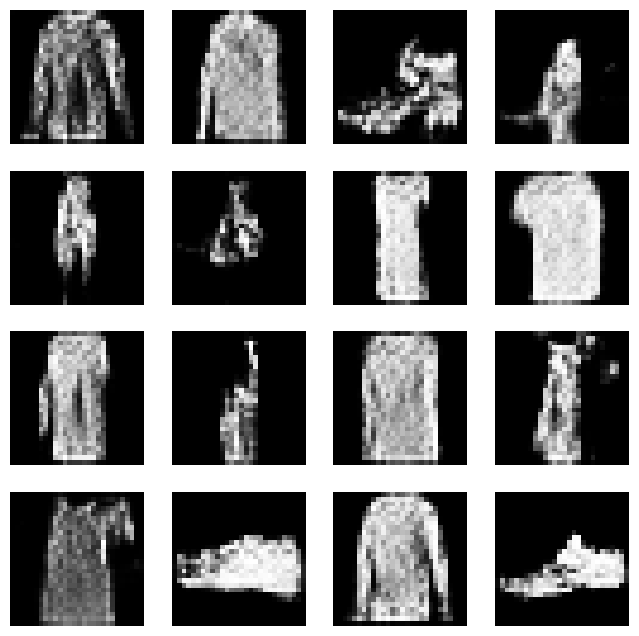

Time for epoch 13 is 5.402563571929932 sec
Epoch 14


2024-12-05 13:17:16.485868: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


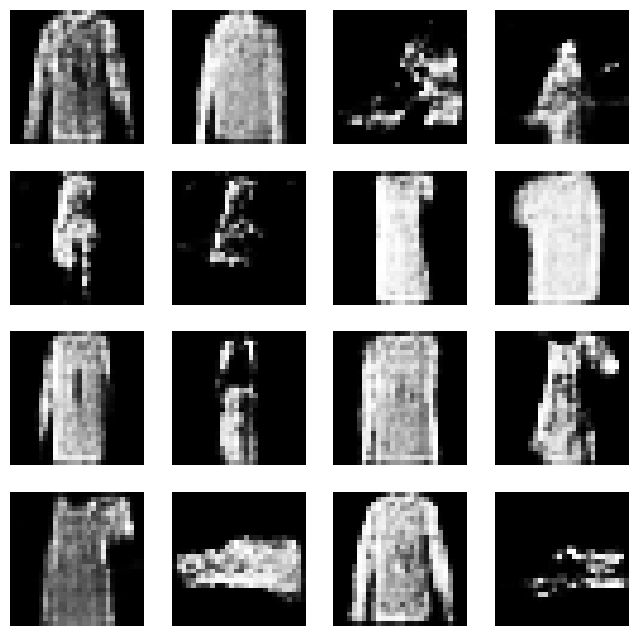

Time for epoch 14 is 5.629540920257568 sec
Epoch 15


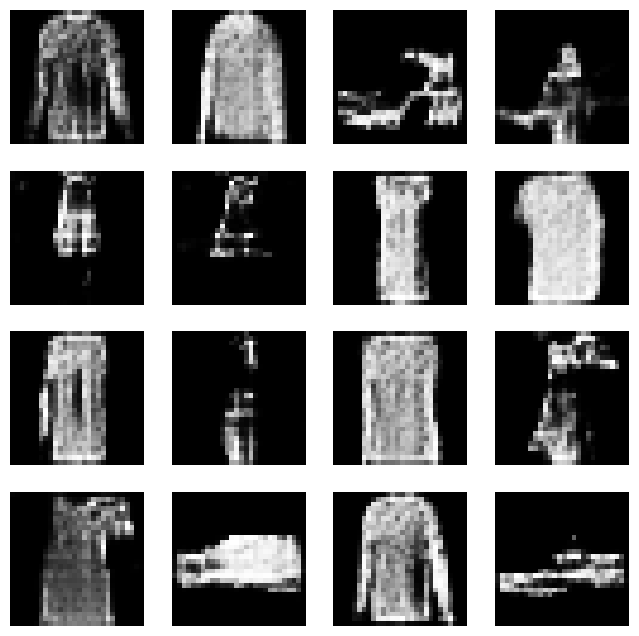

Time for epoch 15 is 5.3941192626953125 sec
Epoch 16


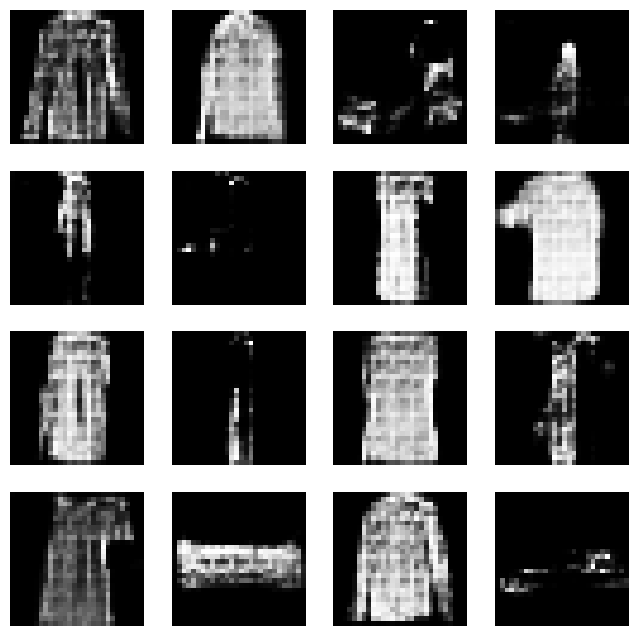

Time for epoch 16 is 5.397826910018921 sec
Epoch 17


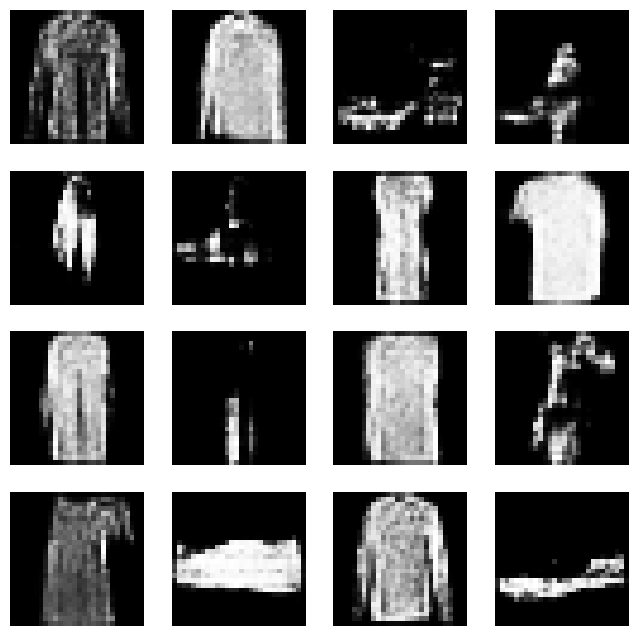

Time for epoch 17 is 5.398813009262085 sec
Epoch 18


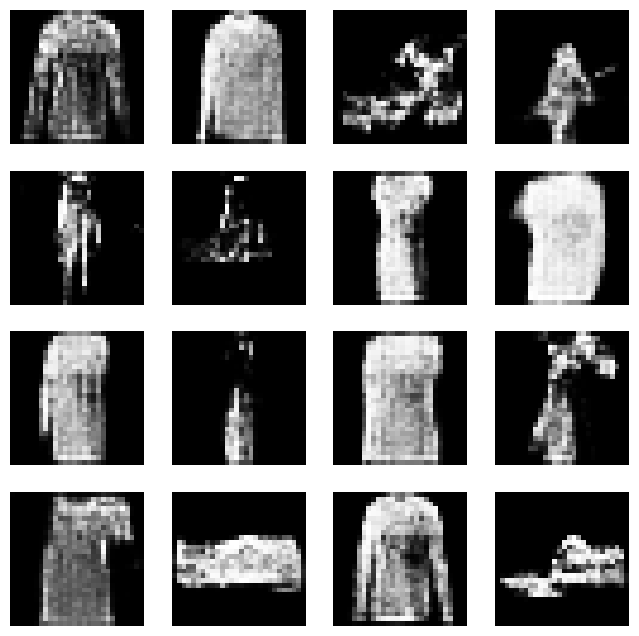

Time for epoch 18 is 5.3962085247039795 sec
Epoch 19


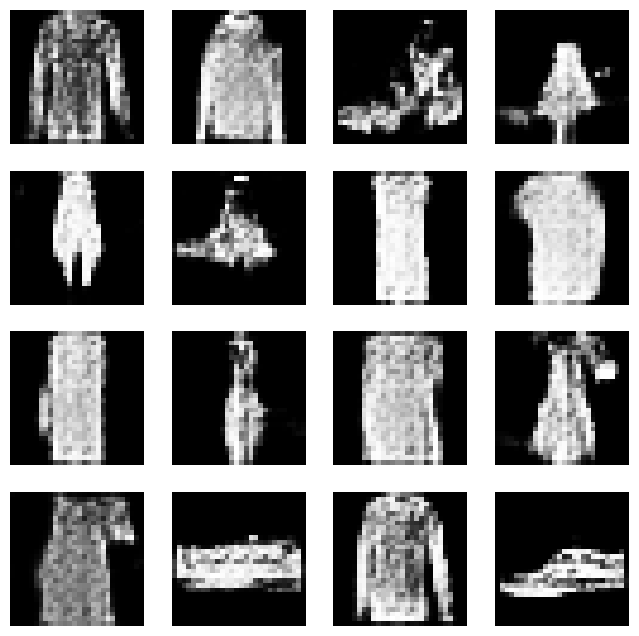

Time for epoch 19 is 5.647371530532837 sec
Epoch 20


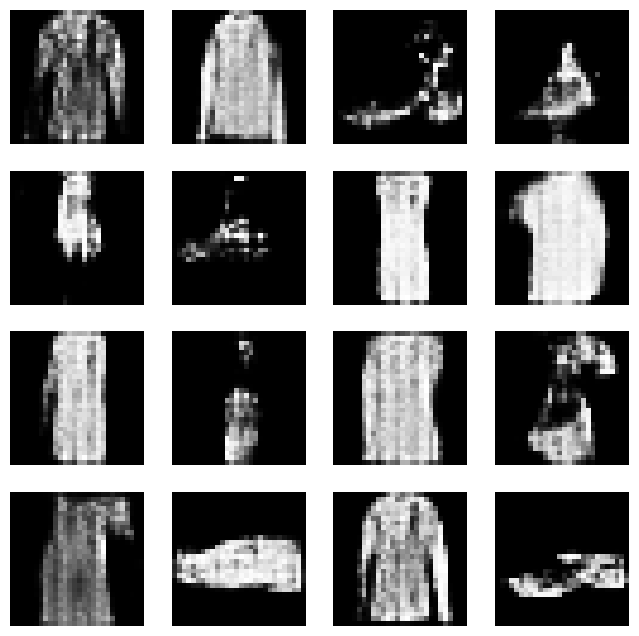

Time for epoch 20 is 5.406742095947266 sec
Epoch 21


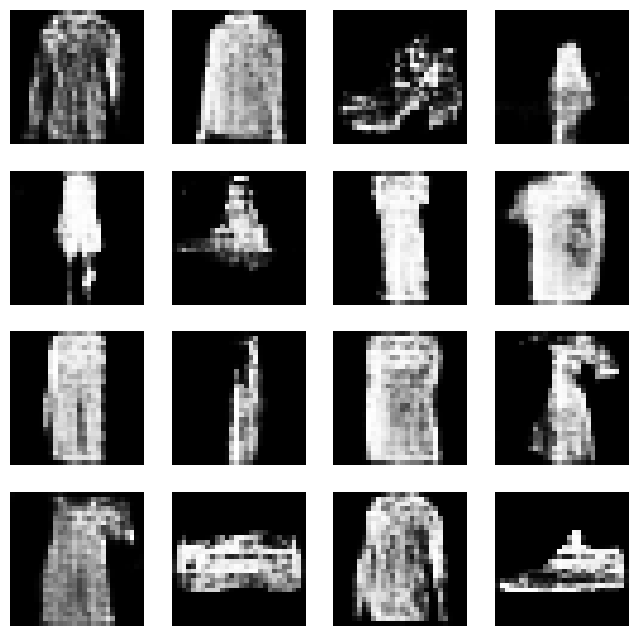

Time for epoch 21 is 5.405835390090942 sec
Epoch 22


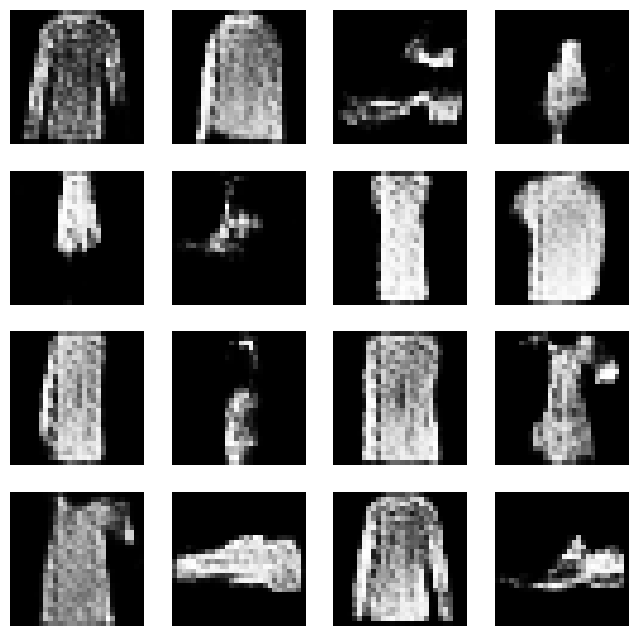

Time for epoch 22 is 5.408357620239258 sec
Epoch 23


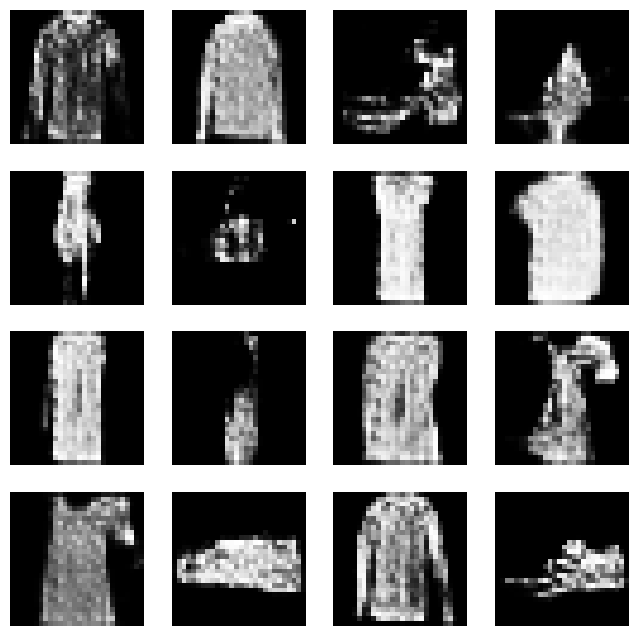

Time for epoch 23 is 5.6450276374816895 sec
Epoch 24


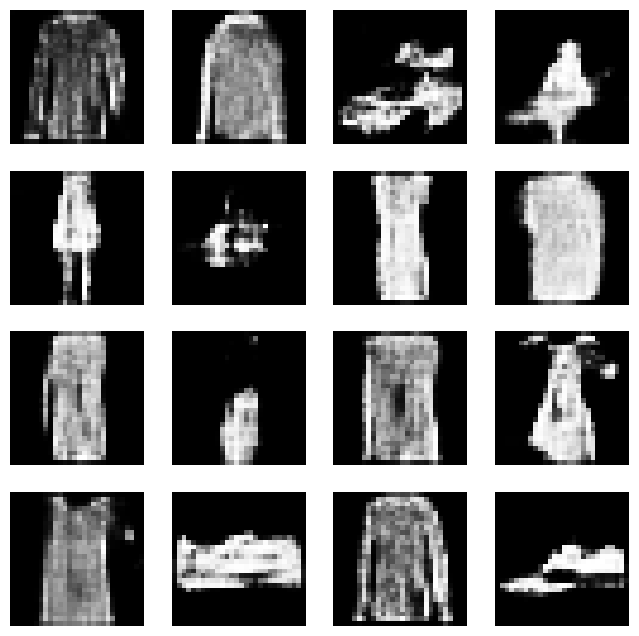

Time for epoch 24 is 5.405150651931763 sec
Epoch 25


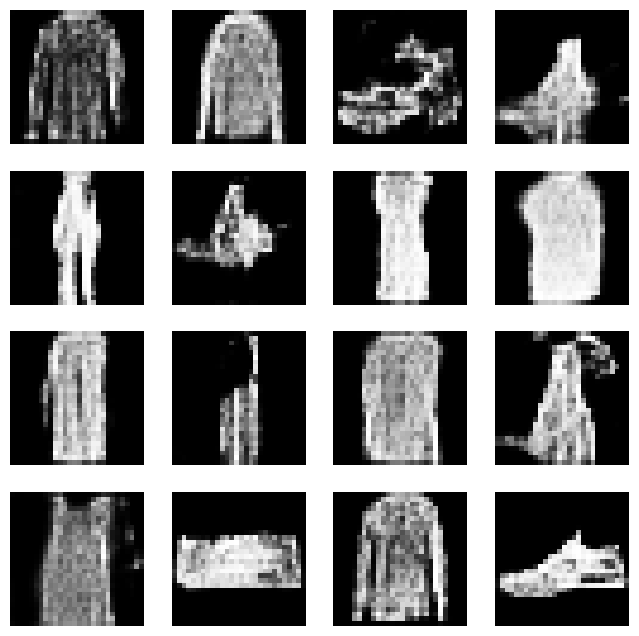

Time for epoch 25 is 5.405675172805786 sec
Epoch 26


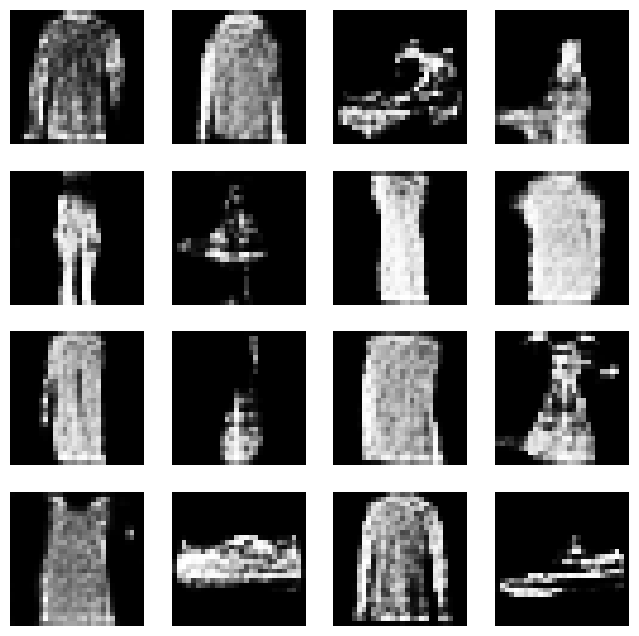

Time for epoch 26 is 5.402746200561523 sec
Epoch 27


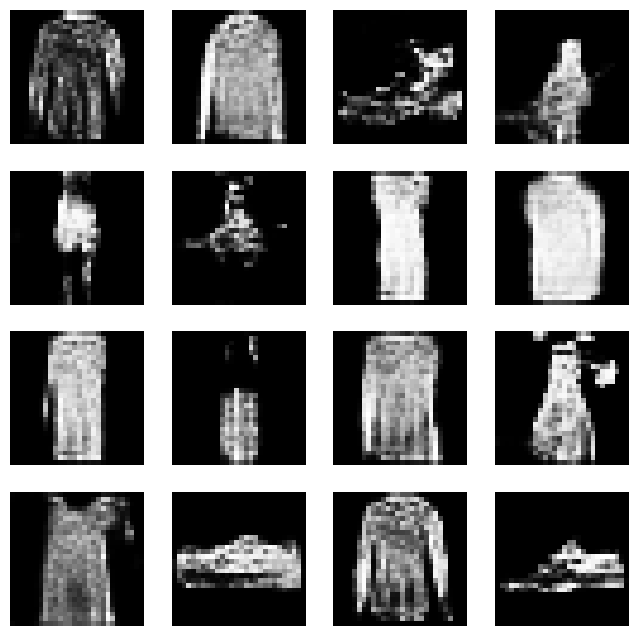

Time for epoch 27 is 5.39885687828064 sec
Epoch 28


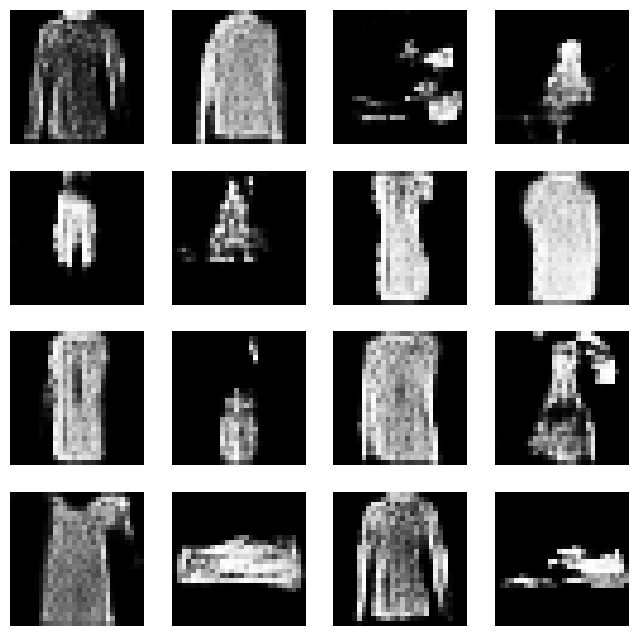

Time for epoch 28 is 5.661672592163086 sec
Epoch 29


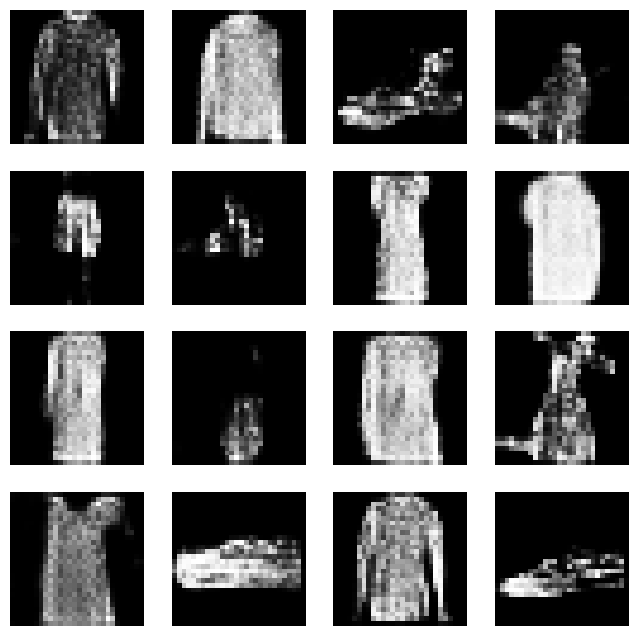

Time for epoch 29 is 5.402557373046875 sec
Epoch 30


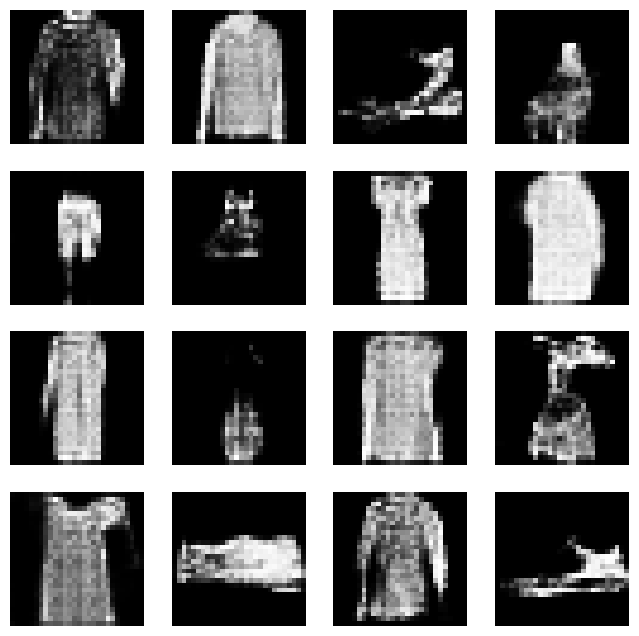

Time for epoch 30 is 5.402877569198608 sec
Epoch 31


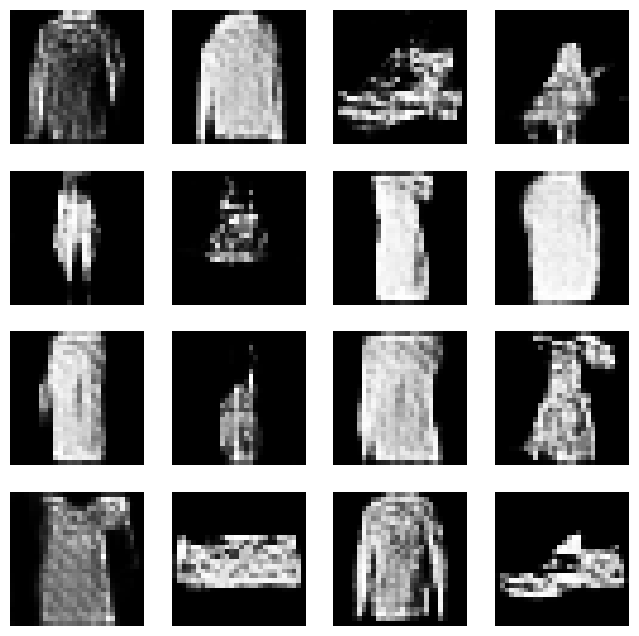

Time for epoch 31 is 5.399361848831177 sec
Epoch 32


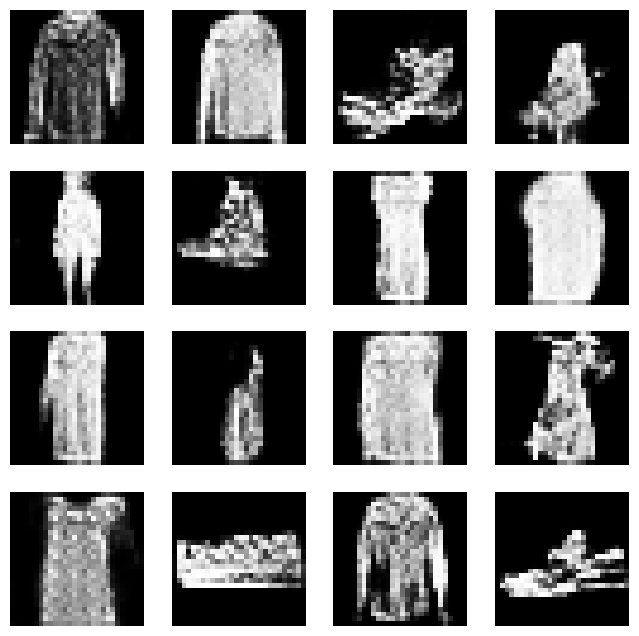

Time for epoch 32 is 5.6232075691223145 sec
Epoch 33


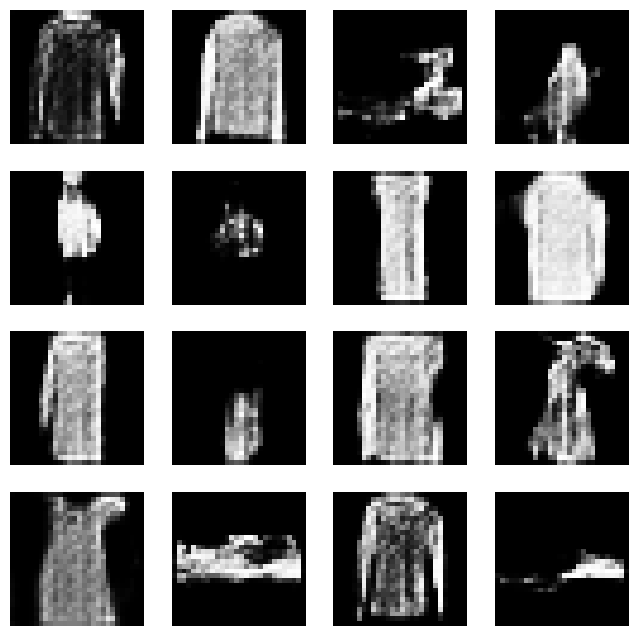

Time for epoch 33 is 5.410537958145142 sec
Epoch 34


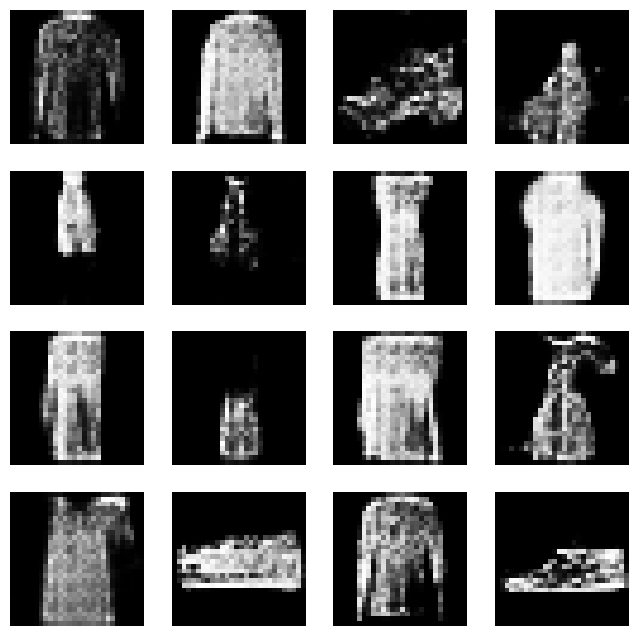

Time for epoch 34 is 5.407787084579468 sec
Epoch 35


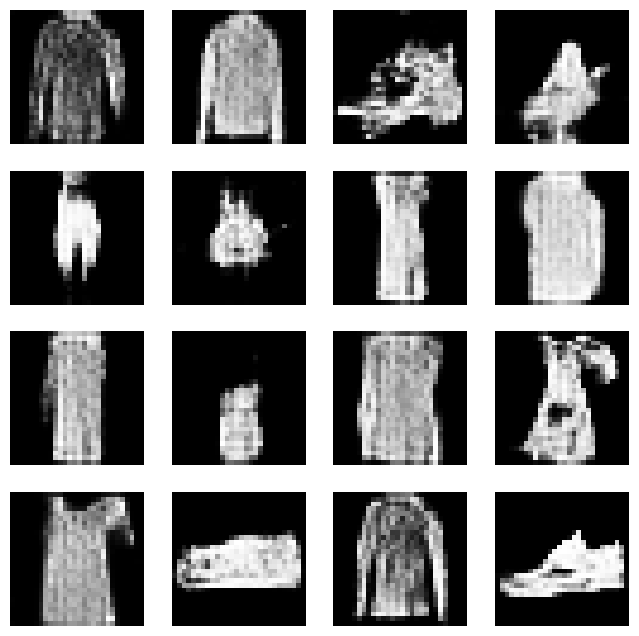

Time for epoch 35 is 5.405232191085815 sec
Epoch 36


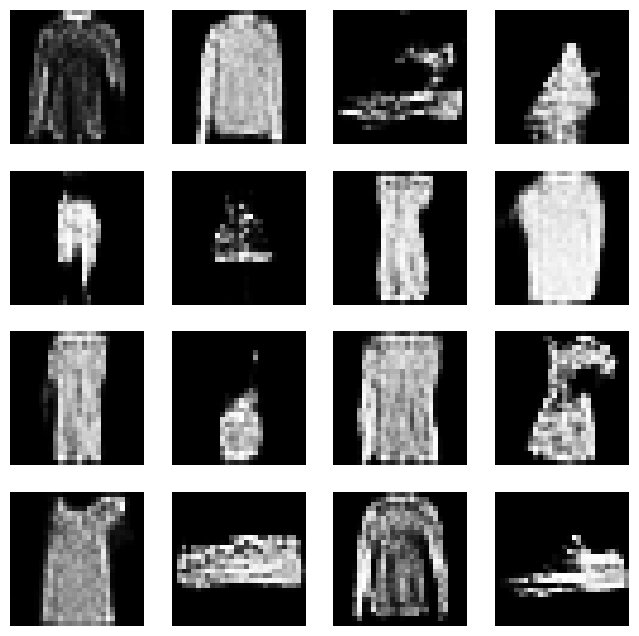

Time for epoch 36 is 5.641661643981934 sec
Epoch 37


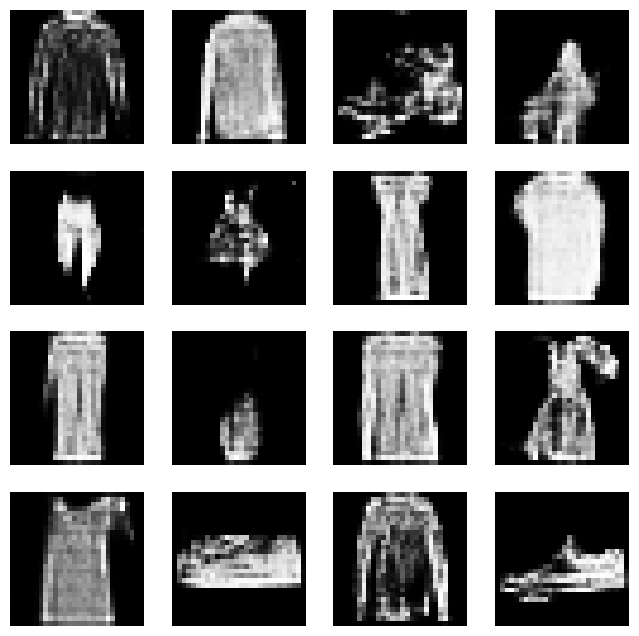

Time for epoch 37 is 5.405071020126343 sec
Epoch 38


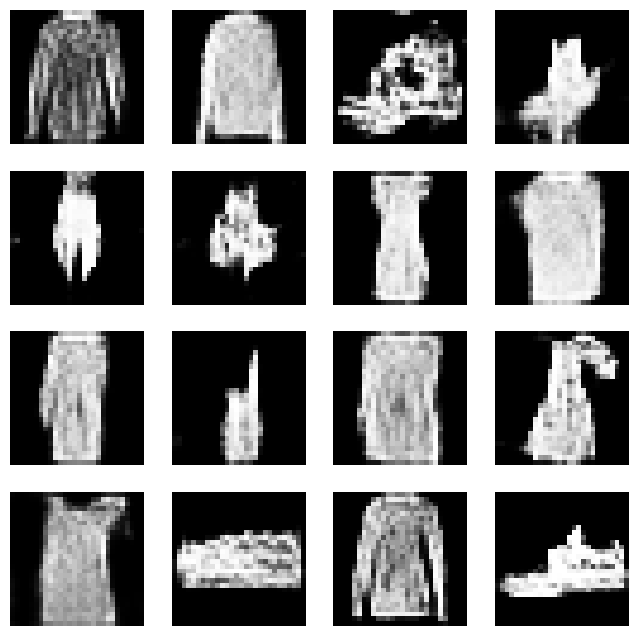

Time for epoch 38 is 5.403320074081421 sec
Epoch 39


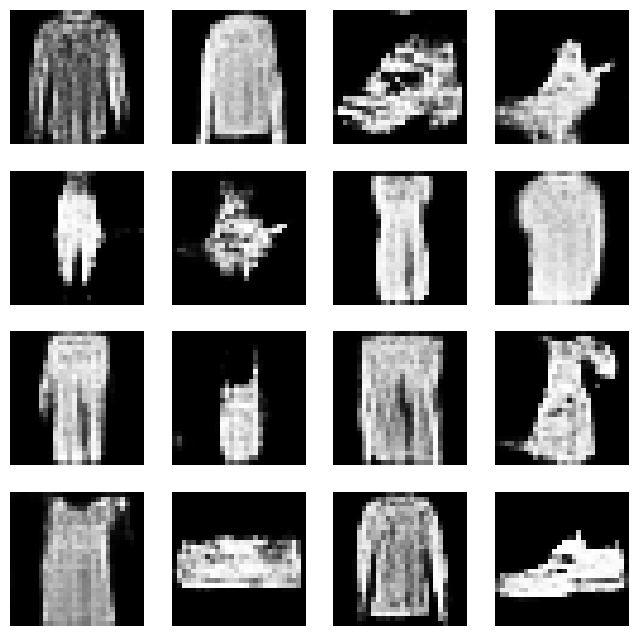

Time for epoch 39 is 5.404959678649902 sec
Epoch 40


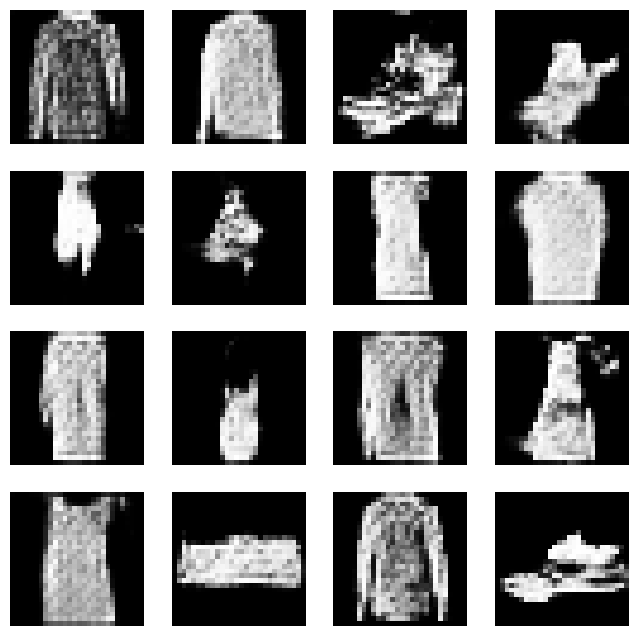

Time for epoch 40 is 5.402661561965942 sec
Epoch 41


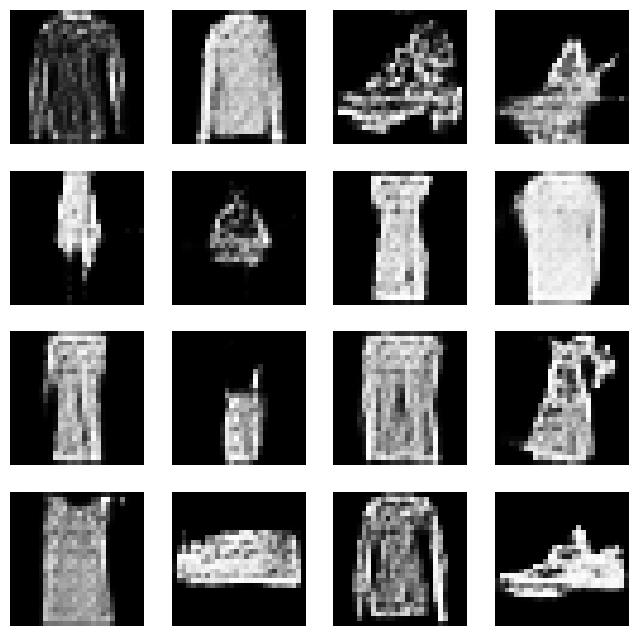

Time for epoch 41 is 5.654046297073364 sec
Epoch 42


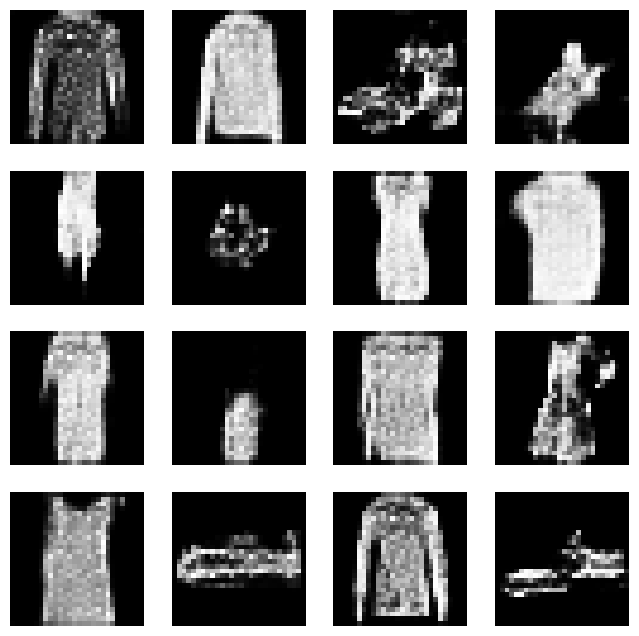

Time for epoch 42 is 5.3996806144714355 sec
Epoch 43


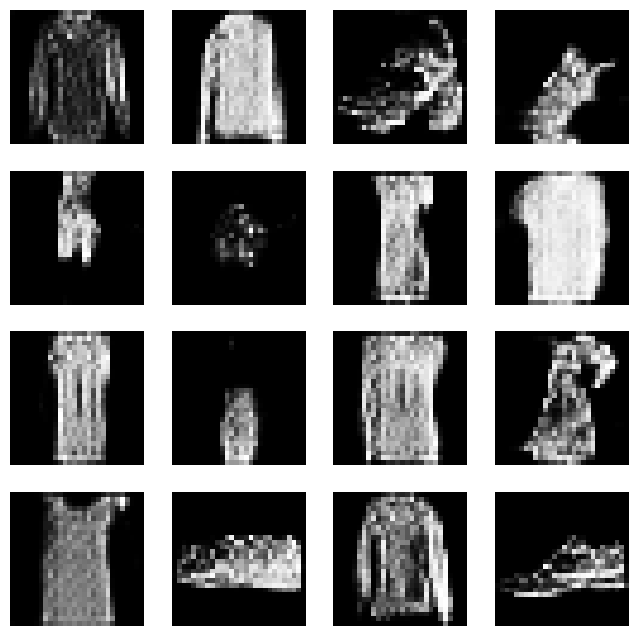

Time for epoch 43 is 5.400258779525757 sec
Epoch 44


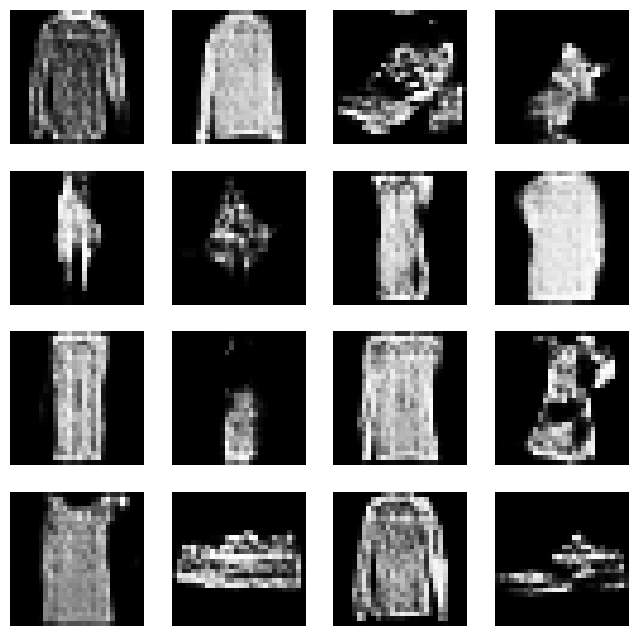

Time for epoch 44 is 5.399637699127197 sec
Epoch 45


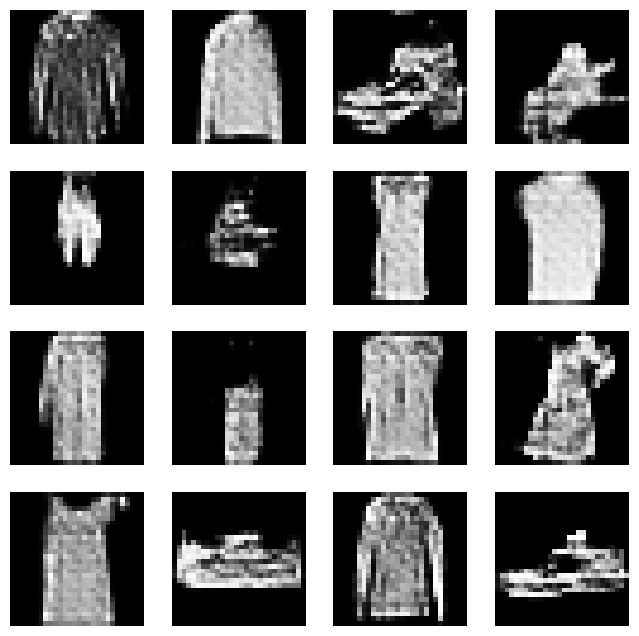

Time for epoch 45 is 5.627828598022461 sec
Epoch 46


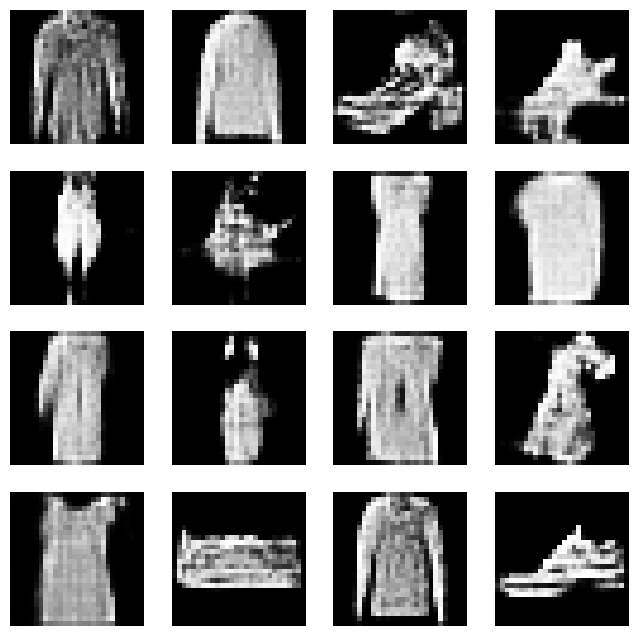

Time for epoch 46 is 5.399416446685791 sec
Epoch 47


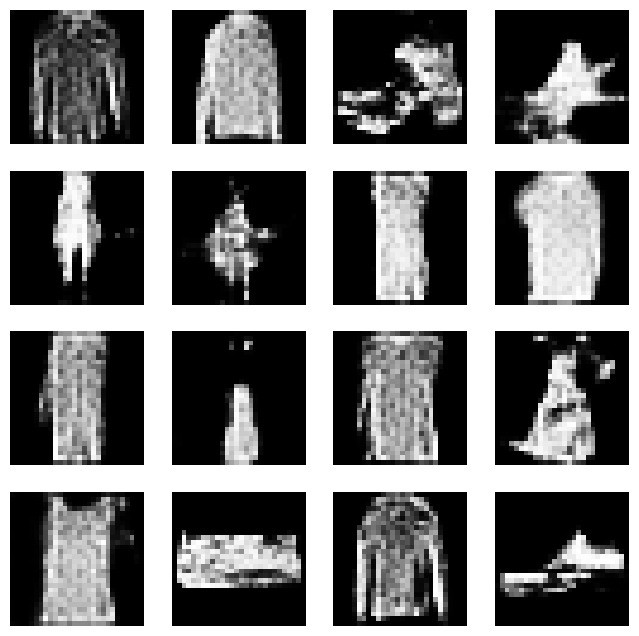

Time for epoch 47 is 5.411713361740112 sec
Epoch 48


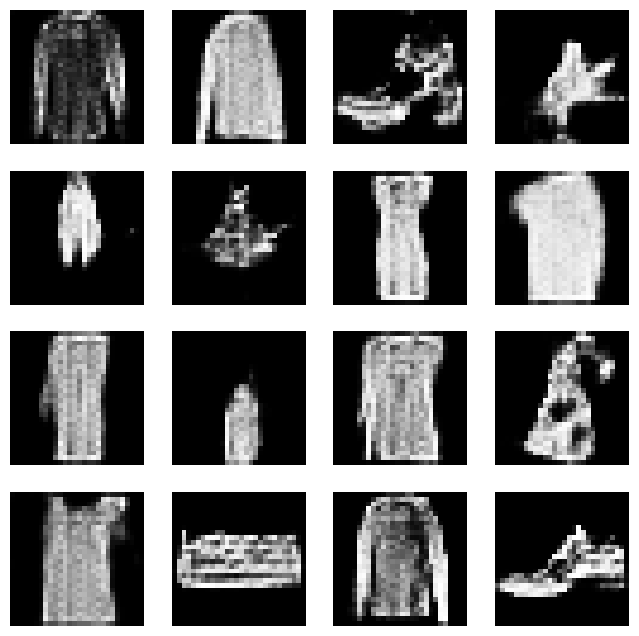

Time for epoch 48 is 5.406389951705933 sec
Epoch 49


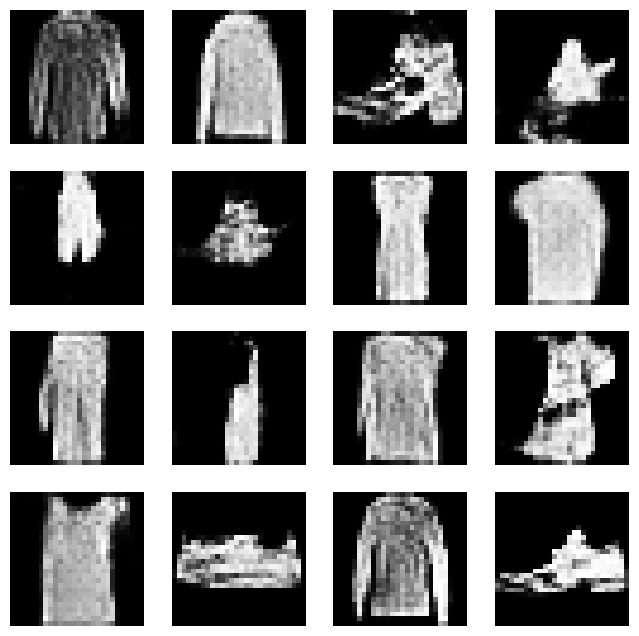

Time for epoch 49 is 5.407103061676025 sec
Epoch 50


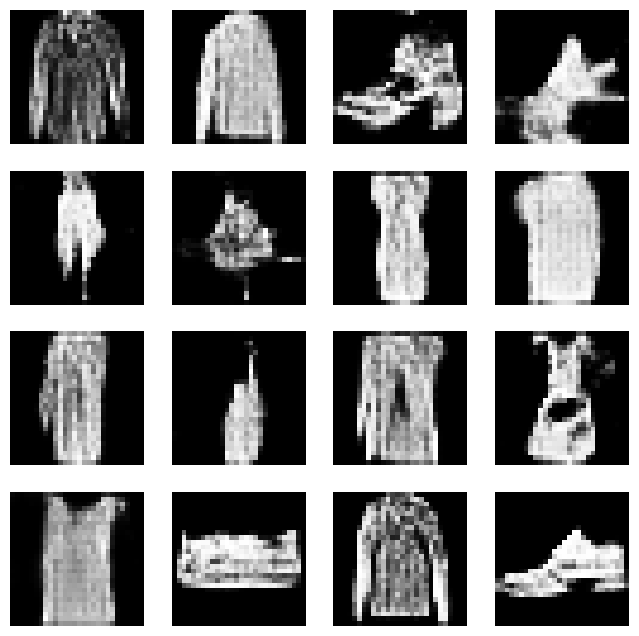

Time for epoch 50 is 5.653502464294434 sec


AttributeError: 'function' object has no attribute 'clear_output'

In [19]:
train(train_dataset, EPOCHS) #Please don't run train on the server, doenload the file and train the net on the local PC
